In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights

C:\Users\Caspe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_image_path = Path(r'../carpet/train')

good_dataset = ImageFolder(root=train_image_path, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)


In [3]:
# resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

# for name in resnet_model.named_parameters():
#     print(name[0])

# resnet_model.layer2

# def hook(model, input, output):
#     feature.append(output.detach())

# feature =[]
# resnet_model.layer2[-1].register_forward_hook(hook)
# resnet_model.layer3[-1].register_forward_hook(hook)

# _ = resnet_model(torch.randn(1,3,224,224))

# feature[1].shape

# Load a pretrained Resnet Model

In [4]:
class resnet18_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained Resnet model."""
        super(resnet18_feature_extractor, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)

        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        

        # Hook to extract feature maps
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.featured."""
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)            
        self.model.layer3[-1].register_forward_hook(hook) 

    def forward(self, input):

        self.features = []
        with torch.no_grad():
            _ = self.model(input)

        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2]         # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1)            # Merge the resized feature maps

        return patch

class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained Resnet model."""
        super(resnet_feature_extractor, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        

        # Hook to extract feature maps
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.featured."""
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)            
        self.model.layer3[-1].register_forward_hook(hook) 

    def forward(self, input):

        self.features = []
        with torch.no_grad():
            _ = self.model(input)

        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2]         # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1)            # Merge the resized feature maps

        return patch


In [5]:
backbone = resnet18_feature_extractor()
weights = backbone.model.conv1.weight.clone()
# weights_1 = weights[:,0:1,:,:,].clone()
weights_avg = torch.mean(backbone.model.conv1.weight.clone(), dim=1, keepdim=True)
# weights = torch.cat([weights, weights_avg], dim=1)
backbone.model.conv1.weight = torch.nn.Parameter(weights)
print(weights.shape)
# backbone.model.conv1 = torch.nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
print(backbone)
print(backbone.model.fc.weight.shape)

torch.Size([64, 3, 7, 7])
resnet18_feature_extractor(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=

torch.Size([1, 128, 28, 28])
torch.Size([1, 256, 14, 14])
torch.Size([1, 384, 28, 28])


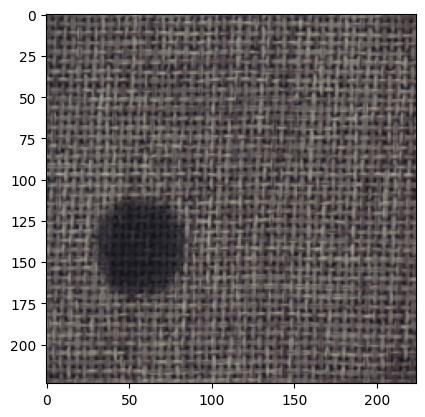

In [6]:


image = Image.open(r'..\carpet\test\color\000.png')
image = transform(image).unsqueeze(0)

# backbone = resnet_feature_extractor()
feature = backbone(image)

print(backbone.features[0].shape)
print(backbone.features[1].shape)

print(feature.shape)

plt.imshow(image[0].permute(1,2,0))

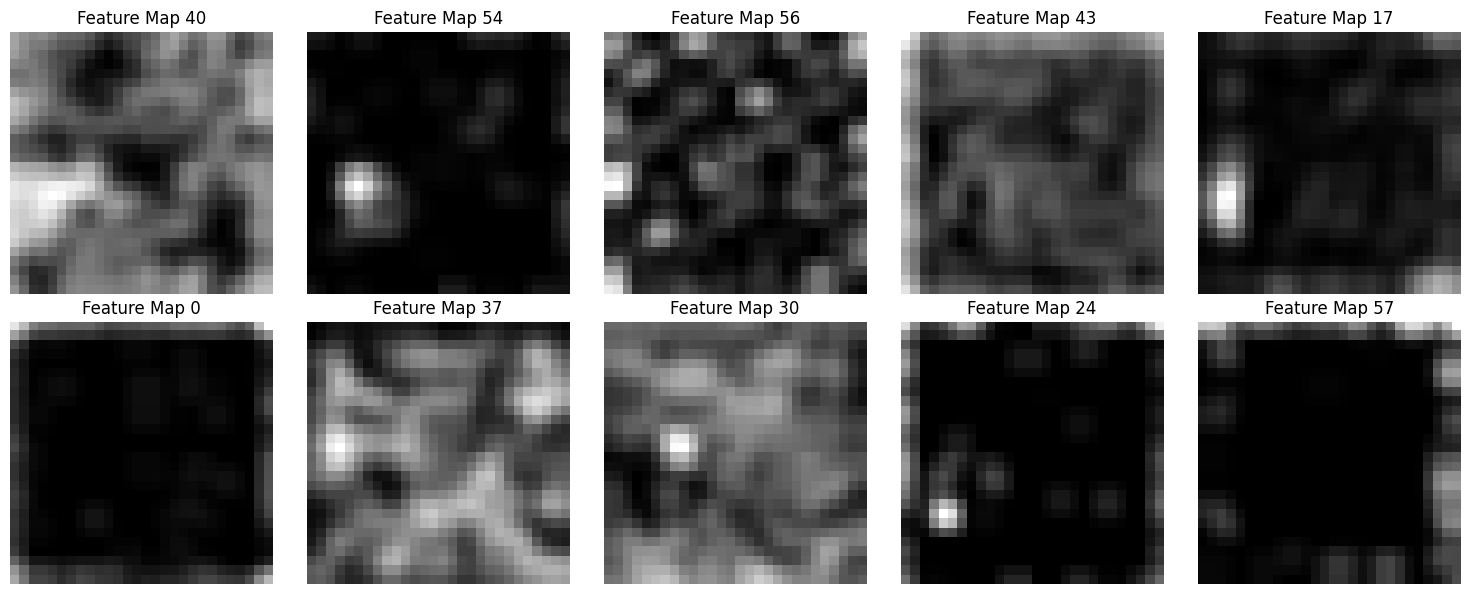

In [7]:

# Select 10 random indices for feature maps
indices = torch.randperm(64)[:10]

# Plot the selected feature maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(feature[0,idx].detach().cpu(), cmap='gray')
    axes[row, col].set_title(f'Feature Map {idx}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# The autoencoder model

In [8]:
import torch.nn as nn

class FeatCAE(nn.Module):
    """Autoencoder."""

    def __init__(self, in_channels=1000, latent_dim=50, is_bn=True):
        super(FeatCAE, self).__init__()

        layers = []
        layers += [nn.Conv2d(in_channels, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, latent_dim, kernel_size=1, stride=1, padding=0)]

        self.encoder = nn.Sequential(*layers)

        # if 1x1 conv to reconstruct the rgb values, we try to learn a linear combination
        # of the features for rgb
        layers = []
        layers += [nn.Conv2d(latent_dim, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, in_channels, kernel_size=1, stride=1, padding=0)]
        # layers += [nn.ReLU()]

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
model = FeatCAE(in_channels=1536, latent_dim=100).cuda()
backbone.cuda()
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#ckpoints = torch.load('autoencoder_with_resnet_deep_features.pth')
#model.load_state_dict(ckpoints)

#model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'autoencoder_with_resnet_deep_features.pth'

In [ ]:
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []


num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    for data,_ in train_loader:
        with torch.no_grad():
            features = backbone(data.cuda())
        # Forward pass
        output = model(features)
        # Compute the loss
        loss = criterion(output, features)
        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())

    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for data, _ in test_loader:
            features = backbone(data.cuda())
            output = model(features)
            val_loss = criterion(output, features)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [868, 1536, 1, 1], expected input[16, 384, 28, 28] to have 1536 channels, but got 384 channels instead

In [ ]:
# torch.save(model.state_dict(), 'autoencoder_with_resnet_deep_features.pth')

# Prediction of heatmap

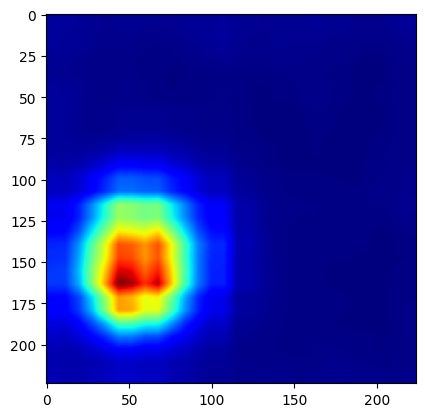

In [ ]:
image = Image.open(r'..\carpet\test\color\000.png')
image = transform(image).unsqueeze(0)

with torch.no_grad():
    features = backbone(image.cuda())
    recon = model(features)

recon_error =  ((features-recon)**2).mean(axis=(1)).unsqueeze(0)

segm_map = torch.nn.functional.interpolate(     # Upscale by bi-linaer interpolation to match the original input resolution
                recon_error,
                size=(224, 224),
                mode='bilinear'
            )

plt.imshow(segm_map.squeeze().cpu().numpy(), cmap='jet')
plt.show()

# For OK images

In [ ]:
def decision_function(segm_map):  

    mean_top_10_values = []

    for map in segm_map:
        # Flatten the tensor
        flattened_tensor = map.reshape(-1)

        # Sort the flattened tensor along the feature dimension (descending order)
        sorted_tensor, _ = torch.sort(flattened_tensor,descending=True)

        # Take the top 10 values along the feature dimension
        mean_top_10_value = sorted_tensor[:10].mean()

        mean_top_10_values.append(mean_top_10_value)

    return torch.stack(mean_top_10_values)

In [ ]:
model.eval()

RECON_ERROR=[]
for data,_ in train_loader:
    
    with torch.no_grad():
        features = backbone(data.cuda()).squeeze()
        # Forward pass
        recon = model(features)
    # Compute the loss
    segm_map =  ((features-recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    anomaly_score = decision_function(segm_map)
    # anomaly_score = segm_map.mean(axis=(1,2))
    
    RECON_ERROR.append(anomaly_score)
    
RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

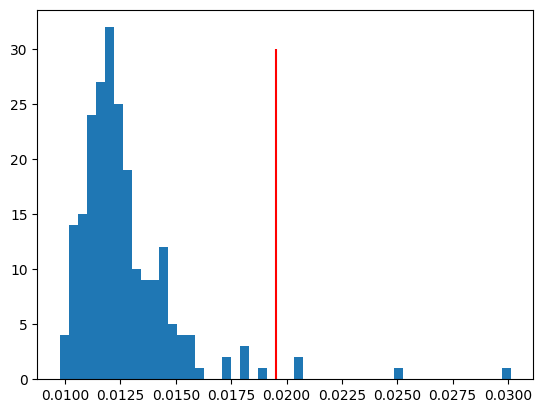

In [ ]:
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

heat_map_max, heat_map_min = np.max(RECON_ERROR), np.min(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

# For Test Images

In [ ]:
y_true=[]
y_pred=[]
y_score=[]

model.eval()
backbone.eval()

test_path = Path('../carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)
    
    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)
    
    segm_map = ((features - recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    y_score_image = decision_function(segm_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))
    
    y_pred_image = 1*(y_score_image >= best_threshold)
    
    y_true_image = 0 if fault_type == 'good' else 1
    
    y_true.append(y_true_image)
    y_pred.append(y_pred_image.cpu().numpy())
    y_score.append(y_score_image.cpu().numpy())
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)
    

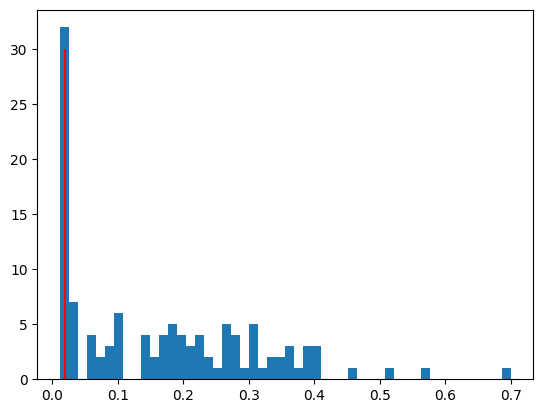

In [ ]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

AUC-ROC Score: 0.9871589085072231


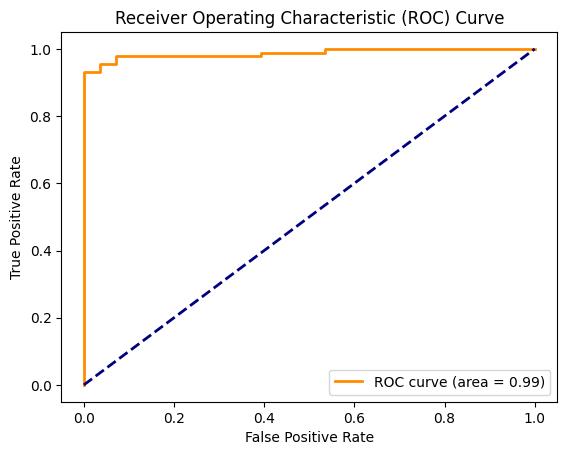

best_threshold = 0.02345464937388897


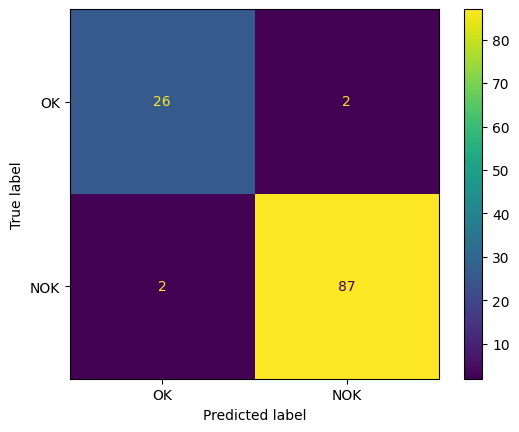

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score



# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()


# Printout the prediction on the test set

In [ ]:
import cv2, time
from IPython.display import clear_output

model.eval()
backbone.eval()

test_path = Path('carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)
    
    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)
    
    segm_map = ((features - recon)**2).mean(axis=(1))
    y_score_image = decision_function(segm_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))
    
    y_pred_image = 1*(y_score_image >= best_threshold)
    class_label = ['OK','NOK']

    if fault_type in ['thread']:

        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy())
        plt.title(f'fault type: {fault_type}')

        plt.subplot(1,3,2)
        heat_map = segm_map.squeeze().cpu().numpy()
        heat_map = heat_map
        heat_map = cv2.resize(heat_map, (128,128))
        plt.imshow(heat_map, cmap='jet', vmin=heat_map_min, vmax=heat_map_max*10) # Here I am cheating by multiplying by 10 (obtained using trail error)
        plt.title(f'Anomaly score: {y_score_image[0].cpu().numpy() / best_threshold:0.4f} || {class_label[y_pred_image]}')

        plt.subplot(1,3,3)
        plt.imshow((heat_map > best_threshold * 10), cmap='gray')
        plt.title(f'segmentation map')
        
        plt.show()

        # time.sleep(0.05)
        # clear_output(wait=True)

        # break


    
    


In [ ]:
import cv2, time
from IPython.display import clear_output

model.eval()
backbone.eval()

test_path = Path('carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)
    
    with torch.no_grad():
        features = backbone(test_image)
        # Forward pass
        recon = model(features)
    
    segm_map = ((features - recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    y_score_image = decision_function(segm_map=segm_map)
    # y_score_image = segm_map.mean(axis=(1,2))
    
    y_pred_image = 1*(y_score_image >= best_threshold)
    class_label = ['OK','NOK']

    if fault_type in ['color','thread']:

        plt.figure(figsize=(10,5))

        plt.subplot(1,2,1)
        plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy())
        plt.title(f'fault type: {fault_type}')

        plt.subplot(1,2,2)
        heat_map = segm_map.squeeze().cpu().numpy()
        heat_map = heat_map
        heat_map = cv2.resize(heat_map, (128,128))
        plt.imshow(heat_map, cmap='jet', vmin=heat_map_min, vmax=heat_map_max*2)
        plt.title(f'Anomaly score: {y_score_image[0].cpu().numpy() / best_threshold:0.4f} || {class_label[y_pred_image]}')
        
        plt.show()

        time.sleep(0.05)
        clear_output(wait=True)

    
    
